# Detecting Multiple Paternity in White-tailed Deer

##### A 2bRAD data analysis pipeline walkthrough

Adam Koller - Luther College '24 - 2022

---

### Importing libraries

In [3]:
import rpy2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import scipy.stats

In [4]:
%load_ext rpy2.ipython
%R .libPaths("~/Programs/R/x86_64-pc-linux-gnu-library/4.1")

'/home/LC/...,'/usr/loca...,'/usr/lib/...,'/usr/lib/...


In [5]:
%%capture importLibraries
%%R
library(ggplot2)
library(ggrepel)
library(sets)
library(dplyr)

In [133]:
# Changing working directory (set equal to project folder)
os.environ['WORKDIR'] = './DeerProject'

### Adding software to path

In [134]:
path = '/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/opt/anaconda3/bin' # <- insert current paths into this string
path += ':/home/LC/kollad01/Programs/2bRAD_denovo' # Enter path to directory with scripts
path += ':/home/LC/kollad01/.local/bin'
path += ':home/LC/kollad01/Programs/bowtie2-2.4.5-mingw-x86_64'
path += ':home/LC/kollad01/Programs/samtools-1.15.1'
path += ':/home/LC/kollad01/Programs/angsd'
path += ':/home/LC/kollad01/Programs/angsd/NgsRelate'
path += ':/home/LC/kollad01/Programs/htslib'
path += ':/home/LC/kollad01/Programs/R/x86_64-pc-linux-gnu-library/4.1'
os.environ['PATH'] = path

In [135]:
print(os.environ['PATH'])

/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/opt/anaconda3/bin:/home/LC/kollad01/Programs/2bRAD_denovo:/home/LC/kollad01/.local/bin:home/LC/kollad01/Programs/bowtie2-2.4.5-mingw-x86_64:home/LC/kollad01/Programs/samtools-1.15.1:/home/LC/kollad01/Programs/angsd:/home/LC/kollad01/Programs/angsd/NgsRelate:/home/LC/kollad01/Programs/htslib:/home/LC/kollad01/Programs/R/x86_64-pc-linux-gnu-library/4.1


### Understanding Data Structure

200 samples (195 unique, 5 replicates) split among 17 .fastq files.

In [138]:
%%bash
head Data/ILL-RAD01_S1_L001_R1_001.fastq

@J00102:28:HTWWLBBXX:1:1101:2747:1050 1:N:0:NTCACG
NGAACCGGCACAACCCAGCGAGGCACCTGCCTTTGGCCAGCCTCACAGAT
+
#AAFFJJJJJJJJJJJJJJJJJJAJJJJJJJJFJJJJJJ<JJJJJJJJAJ
@J00102:28:HTWWLBBXX:1:1101:3072:1050 1:N:0:NTCACG
NGAACCAGGACGCCGATGGCAACATCGTCGAACTGCGTTGCTGTGAAGAT
+
#AA<FFFFJFJJJJJJJJJJAFJJJJJJJJJJJAJJJJFJF-FJJJFJFF
@J00102:28:HTWWLBBXX:1:1101:3579:1050 1:N:0:NTCACG
NGAACCGGCTGGCCAAGGGCAGGGGCCTCGCTGGGTTGTGCCTCAGAGAT


50bp chunks: N(18) CGA N(6) TGC N(12) 4bp barcode

### Counting raw reads

In [12]:
barcodes = ['GTGT','AGAC','ACCA','AGTG','CATC','GTGA','TCAG','GCTT','CTAC','TGTC','TCAC','GACT'] # <- Our barcodes

In [81]:
# Function to count reads for each barcode w/wo bcg1 enzyme site. Input directory path with .fastq files, list of barcodes, 
# and bcg1 TRUE/FALSE
def count(directoryName, barcodes, bcg1Bool):  
    barCounts = {'Unmatched':0} # initialize dictionary
    for fileName in os.listdir(directoryName): # iterate through list of file paths
        if fileName.endswith(".fastq"): # ignore files not ending in .fastq
            fileID = fileName.split("_")[1] # ID contains well info used to distinguish samples
            file = open(directoryName+fileName, 'r') # open file
            count = 0 # count variable to ready every 4 lines (lines with sequence)
            for line in file: # iterate through lines of file
                if count%4 == 1: # "every 4th line"
                    enzymeSite = line[18:30] # This is the index of the bcg1 enzyme site
                    if bcg1Bool: # If we restrict counting to sequences containing bcg1 site
                        if (enzymeSite[0:3] == 'CGA' and enzymeSite[9:12] == 'TGC') \ # bcg1 sequence
                        or (enzymeSite[0:3] == 'GCA' and enzymeSite[9:12] == 'TCG'): # or its reverse complement
                            barID = fileID + "_" + line[42:46] #42:46 is the position of our 4bp barcode
                            try:
                                barCounts[barID] += 1 # increase count in dictionary with that barcode
                            except:
                                if line[42:46] in barcodes: # make sure it is a valid barcode                      
                                    barCounts[barID] = 1 # Otherwise add barcode to dictionary with count 1
                                else:
                                    barCounts['Unmatched'] += 1 # Invalid barcodes are thrown in unmatched category
                                    
                    # Same thing as above but for case where we are not counting those with bcg1 site
                    else:
                        barID = fileID + "_" + line[42:46] 
                        try:
                            barCounts[barID] += 1
                        except:
                            if line[42:46] in barcodes:                       
                                barCounts[barID] = 1
                            else:
                                barCounts['Unmatched'] += 1
                count += 1
    def writeCountstoFile(outputName):  # function to write count data to csv file
        reads = []
        for ID in barCounts.keys():
            reads.append({"ID":ID,outputName+"_count":barCounts[ID]})
        reads = pd.DataFrame.from_dict(reads)
        reads.to_csv('./Output/'+outputName+'_counts.csv', index=False)
        
    if bcg1Bool: # Naming csv files properly 
        writeCountstoFile('bcg1')
    else:
        writeCountstoFile('raw')

In [75]:
%%time
count('Data/',barcodes, False)

ILL-RAD09_S9_L001_R1_001.fastq
ILL-RAD06_S6_L001_R1_001.fastq
ILL-RAD17_S17_L001_R1_001.fastq
ILL-RAD11_S11_L001_R1_001.fastq
ILL-RAD10_S10_L001_R1_001.fastq
ILL-RAD02_S2_L001_R1_001.fastq
ILL-RAD13_S13_L001_R1_001.fastq
ILL-RAD03_S3_L001_R1_001.fastq
ILL-RAD15_S15_L001_R1_001.fastq
ILL-RAD08_S8_L001_R1_001.fastq
ILL-RAD04_S4_L001_R1_001.fastq
ILL-RAD16_S16_L001_R1_001.fastq
ILL-RAD05_S5_L001_R1_001.fastq
ILL-RAD07_S7_L001_R1_001.fastq
ILL-RAD01_S1_L001_R1_001.fastq
ILL-RAD14_S14_L001_R1_001.fastq
ILL-RAD12_S12_L001_R1_001.fastq
CPU times: user 5min 57s, sys: 40.5 s, total: 6min 38s
Wall time: 6min 4s


In [76]:
raw_reads = pd.read_csv('Output/raw_counts.csv')
print(sum(raw_reads['raw_count']), 'total reads (including unmatched)')

343721394 total reads (including unmatched)


In [25]:
def describeCounts(fileName): # Function to give basic statistics for count data
    raw_count = pd.read_csv(fileName) # Read in file
    omitted = ['S17_CTAC','S17_TGTC','S17_TCAC','S17_GACT','Unmatched'] # Count function created barcodes that are not samples
    raw_count.drop(raw_count[raw_count['ID'].isin(omitted)].index, inplace =True) # Exclude previous barcodes
    sns.histplot(data=raw_count, x = raw_count.columns[1], fill=False) # Create histogram with seaborn
    plt.axvline(raw_count.iloc[:,1].median(), color='green', linestyle='dashed') # median vertical line
    plt.axvline(raw_count.iloc[:,1].mean(), color='red', linestyle='dashed') # mean vertical line
    print(raw_count.describe().round()) # show stats

       raw_count
count      200.0
mean   1659439.0
std    1431810.0
min      12717.0
25%     739973.0
50%    1311156.0
75%    1976969.0
max    9650018.0


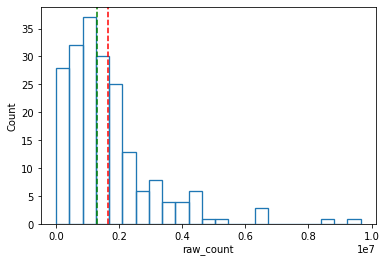

In [78]:
describeCounts("Output/raw_counts.csv")

In [79]:
%%time
count('./Data/',barcodes, True)

ILL-RAD09_S9_L001_R1_001.fastq
ILL-RAD06_S6_L001_R1_001.fastq
ILL-RAD17_S17_L001_R1_001.fastq
ILL-RAD11_S11_L001_R1_001.fastq
ILL-RAD10_S10_L001_R1_001.fastq
ILL-RAD02_S2_L001_R1_001.fastq
ILL-RAD13_S13_L001_R1_001.fastq
ILL-RAD03_S3_L001_R1_001.fastq
ILL-RAD15_S15_L001_R1_001.fastq
ILL-RAD08_S8_L001_R1_001.fastq
ILL-RAD04_S4_L001_R1_001.fastq
ILL-RAD16_S16_L001_R1_001.fastq
ILL-RAD05_S5_L001_R1_001.fastq
ILL-RAD07_S7_L001_R1_001.fastq
ILL-RAD01_S1_L001_R1_001.fastq
ILL-RAD14_S14_L001_R1_001.fastq
ILL-RAD12_S12_L001_R1_001.fastq
CPU times: user 7min 23s, sys: 46.6 s, total: 8min 10s
Wall time: 7min 30s


       bcg1_count
count       200.0
mean    1621326.0
std     1401299.0
min       11924.0
25%      716104.0
50%     1284612.0
75%     1914270.0
max     9452617.0


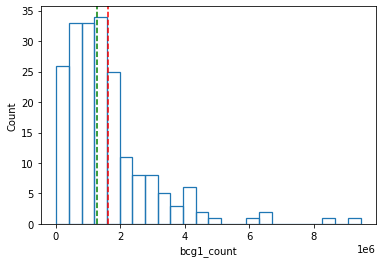

In [80]:
describeCounts("Output/bcg1_counts.csv")

### Splitting by barcode / Removing PCR duplicates

**note.** We changed the variable *minBCcount* from 100000 to 100 in the *trim2bRAD_2barcodes_dedup_N.pl* script found in Mikhael Matz's 2b_RAD Denovo scripts cloned from github. We did this in order to preserve our samples which contained less than 100000 reads.

In [7]:
%%time
%%capture dedupLog
%%bash
cd Data
2bRAD_trim_launch_dedup_N.pl .fastq > trims
bash trims

CPU times: user 40.2 ms, sys: 25.7 ms, total: 65.9 ms
Wall time: 30min 22s


In [8]:
# Saving output from previous cell to file
f = open("./Output/dedupLog.txt", "w")
for line in dedupLog.stdout.split('\n'):
    f.write(line+'\n')
f.close()

Since we changed *minBCcount*, we created demultiplexed files for barcodes not associated with one of our samples (junk files). The next three cells are removing those files.

In [15]:
def removeJunkFiles(directory, Barcodes):
    files = os.listdir(directory)
    for fileName in files:
        try:
            ext = fileName.split("_")[5]
        except:
            pass
        else:
            bcode = ext[0:4]
            if bcode not in Barcodes:
                os.remove(directory + fileName)

In [16]:
removeJunkFiles('Data/', barcodes)

Removing files that the previous step missed...

In [18]:
%%bash
cd Data
rm ILL-RAD17_S17_L001_R1_001_CTAC.tr0
rm ILL-RAD17_S17_L001_R1_001_TGTC.tr0
rm ILL-RAD17_S17_L001_R1_001_TCAC.tr0
rm ILL-RAD17_S17_L001_R1_001_GACT.tr0

Check that the number of .tr0 files matches number of samples.

In [20]:
%%bash
cd Data
ls *.tr0 | wc -l

200


### Counting reads after removal of PCR duplicates

In [23]:
%%time
%%bash
>./Output/post_dedup_counts.csv
echo "ID,post_dedup_count" >> ./Output/post_dedup_counts.csv;
cd Data
for FILE in *.tr0;
do
    COUNT=`wc -l $FILE`;
    IFS=' '
    read -a strarr <<< "$COUNT"
    COUNT=${strarr[0]}
    let COUNT=$COUNT/4
    IFS='_' read -ra strarr2 <<< $FILE
    ID1=${strarr2[1]}
    ID2=${strarr2[-1]}
    ID2="${ID2:0:4}" 
    OUT=$ID1"_"$ID2","$COUNT
    echo $OUT >> ../Output/post_dedup_counts.csv;
done
    

CPU times: user 4.79 ms, sys: 1.26 ms, total: 6.05 ms
Wall time: 4.13 s


       post_dedup_count
count             200.0
mean           296931.0
std            166819.0
min              5285.0
25%            190888.0
50%            262810.0
75%            382353.0
max           1358318.0


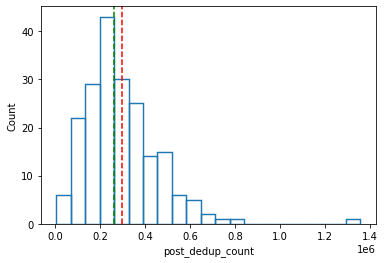

In [26]:
describeCounts('Output/post_dedup_counts.csv')

### Quality filtering

Trimming low-quality base pairs at the end of reads with Cutadapt.

In [37]:
%%time
%%bash
cd Data
> trims
for file in *.tr0; do
echo "cutadapt -q 15,15 -m 25 -o ${file/.tr0/}.trim $file > ${file}.trimlog.txt" >> qFilt; done
bash qFilt

CPU times: user 5.07 ms, sys: 5.53 ms, total: 10.6 ms
Wall time: 3min 16s


Check that we have expected number of .trim files.

In [39]:
%%bash
cd Data
ls *.trim | wc -l

200


### Counting reads after quality filtering

In [40]:
%%time
%%bash
>./Output/post_filt_counts.csv
echo "ID,post_filt_count" >> ./Output/post_filt_counts.csv;
cd Data
for FILE in *.trim;
do
    COUNT=`wc -l $FILE`;
    IFS=' '
    read -a strarr <<< "$COUNT"
    COUNT=${strarr[0]}
    let COUNT=$COUNT/4
    IFS='_' read -ra strarr2 <<< $FILE
    ID1=${strarr2[1]}
    ID2=${strarr2[-1]}
    ID2="${ID2:0:4}" 
    OUT=$ID1"_"$ID2","$COUNT
    echo $OUT >> ../Output/post_filt_counts.csv;
done

CPU times: user 3.31 ms, sys: 2.45 ms, total: 5.75 ms
Wall time: 4.13 s


       post_filt_count
count            200.0
mean          296931.0
std           166819.0
min             5285.0
25%           190888.0
50%           262810.0
75%           382353.0
max          1358318.0


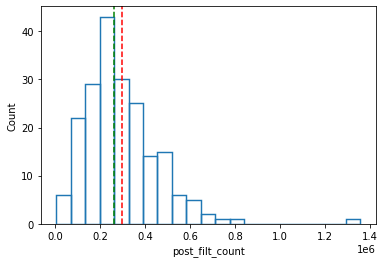

In [42]:
describeCounts('Output/post_filt_counts.csv')

In [279]:
%%bash
head Data/ILL-RAD17_S17_L001_R1_001_GCTT.trim

@J00102:28:HTWWLBBXX:1:1101:10216:1086 1:N:0:NTAGAG bcd=GCTT
AGCGCGTAAACCGCATCGGTATCGTATAGCGTGGCG
+
<FJJAJJJJJJJJJJJJJJAJJJJJJJAFFJJJF<J
@J00102:28:HTWWLBBXX:1:1101:19532:1086 1:N:0:NTAGAG bcd=GCTT
CAGATCCAGACTGCAAACCTATCGTACTCGTTGGCA
+
FFAFJJJJJJJJFJJJJJFFJJJJJJJJJJJJJ<JF
@J00102:28:HTWWLBBXX:1:1101:26991:1103 1:N:0:NTAGAG bcd=GCTT
GACAGCTGGCTGGCAGGCGCCTCGGCCTCCGGTTCG


### Building reference genome

*Odocoileus virginianus* reference genome from the University of Illinois: https://www.ncbi.nlm.nih.gov/data-hub/genome/GCA_023699985.1/

Copy all of the .fna sequence files (one for each chromosome) to a new directory 'genome'

In [48]:
%%bash
mkdir genome 
cd ncbi_dataset/data/GCA_023699985.1
cp *.fna ../../../genome

mkdir: cannot create directory ‘genome’: File exists


2bRAD_denovo
Data
Deer.ipynb
genome
ncbi_dataset
Output


Remove sex chromosomes and unplaced scaffolds from the genome directory

In [49]:
%%bash
rm genome/chrX.fna
rm genome/chrY.fna
rm genome/unplaced.scaf.fna

Concatenate chromosomes together into a single genome file. Remove chromosome files.

In [51]:
%%bash
shopt -s extglob
cd genome
cat *.fna > genome.fasta
rm !("genome.fasta")

Use bowtie2, samtools, and picard to create genome index files. See more on these packages: http://bowtie-bio.sourceforge.net/bowtie2/manual.shtml, http://www.htslib.org/doc/#manual-pages, https://broadinstitute.github.io/picard/.

In [59]:
%%time
%%capture genomeBuild
%%bash
cd genome
bowtie2-build genome.fasta genome.fasta

CPU times: user 124 ms, sys: 53.4 ms, total: 178 ms
Wall time: 1h 33min 49s


In [8]:
%%time
%%bash
cd genome
samtools faidx genome.fasta

CPU times: user 6.26 ms, sys: 430 µs, total: 6.69 ms
Wall time: 9.25 s


In [16]:
%%time
%%capture picardOut
%%bash
# NEED JAVA INSTALLED
#java -jar picard.jar CreateSequenceDictionary R=genome/genome.fasta O=genome/genome.dict

CPU times: user 8.03 ms, sys: 0 ns, total: 8.03 ms
Wall time: 7.34 ms


### Aligning reads to the reference genome

Aligning reads to the reference genome. %%capture keeps record of the standard output which contains useful data on allignment rates.

In [18]:
%%time
%%capture allignmentRates
%%bash
cd Data
2bRAD_bowtie2_launch.pl '\.trim$' ../genome/genome.fasta > maps
bash maps

CPU times: user 157 ms, sys: 76.6 ms, total: 233 ms
Wall time: 1h 21min 3s


Saving standard output from read alligning to a file.

In [21]:
f = open("./Output/allignmentRates.txt", "w")
for line in allignmentRates.stderr.split('\n'):
    f.write(line+'\n')
f.close()

This function takes the data from the file just created, and stores it into a csv file.

In [5]:
# Allignment rate function
def getAllignmentRates(allignFile, output, fileOrder):
    allignFile = open(allignFile, "r")
    orderFile = open(fileOrder ,'r')
    
    order = []
    allignment = []
    readCount = []
    for line in orderFile:
        line = line.split(" ")[-3]
        line = line.split("_")
        ida = line[1]
        idb = line[5].split(".")[0]
        id = ida + "_" + idb
        order.append(id)
        
    count = 0
    for line in allignFile:
        if count%6 ==0:
            reads = line.strip().split(" ")[0]
            readCount.append(reads)
        
        if count % 6 == 5:
            line = line.strip()
            percent = line.split(" ")[0][0:-1]
            allignment.append(percent) 
        count += 1    
    df_allign = []
    
    for i in range(len(order)):
        df_allign.append({'ID':order[i], 'reads':readCount[i],'allignment_rate':allignment[i]})
        
    df_allign = pd.DataFrame.from_dict(df_allign)
    df_allign.to_csv('./Output/allignmentRates'+output+'.csv', index=False)


In [6]:
getAllignmentRates('./Output/allignmentRates.txt','','./Data/maps')

In [346]:
#Importing files with pandas
countRaw = pd.read_csv("./Output/raw_counts.csv")
countBcg1 = pd.read_csv("./Output/bcg1_counts.csv")
countPostDedup = pd.read_csv("./Output/post_dedup_counts.csv")
countPostFiltering = pd.read_csv("./Output/post_filt_counts.csv")
allignmentRate = pd.read_csv("./Output/allignmentRates.csv")
sampleWell = pd.read_csv("./SampleData/well_plate.csv")
sampleWell = sampleWell.rename(columns={"Sample ID":"ID"})

# Merging dataframes
countsMerged = countRaw.merge(countBcg1, how='right')
countsMerged = countsMerged.merge(countPostDedup, how='right')
countsMerged = countsMerged.merge(countPostFiltering, how='right')
countsMerged = countsMerged.merge(allignmentRate, how = 'right')
countsMerged = countsMerged.merge(sampleWell, how = 'right')

# Calculating zscores, changing col names, and merging to main dataframe
numeric_cols = countsMerged.select_dtypes(include=[np.number]).columns
zscores = countsMerged[numeric_cols].apply(scipy.stats.zscore)
zscores = zscores.rename(columns=lambda x: x+"_Z")
countsMerged = pd.concat([countsMerged, zscores], axis = 1)

countsMerged.to_csv('./Output/readCountSummary.csv', index=False)
display(countsMerged)

print('Weighted average allignment rate: ',round(sum(countsMerged['allignment_rate'] * countsMerged['reads'])/sum(countsMerged['reads']),2),"%",sep='')
print('Non-weighted average allignment rate: ', round(sum(countsMerged['allignment_rate'])/len(countsMerged['allignment_rate']),2),"%", sep='')

,ID,raw_count,bcg1_count,post_dedup_count,post_filt_count,reads,allignment_rate,Sample Number,raw_count_Z,bcg1_count_Z,post_dedup_count_Z,post_filt_count_Z,reads_Z,allignment_rate_Z
0,S7_TGTC,4324452,4235342,517398,517398,517398,28.83,1,1.865960,1.870104,1.324911,1.324911,1.324911,-0.848647
1,S10_AGTG,2511035,2444053,496764,496764,496764,4.17,2,0.596262,0.588590,1.200909,1.200909,1.200909,-1.712575
2,S13_CTAC,2195954,2166437,411489,411489,411489,0.45,3,0.375652,0.389980,0.688443,0.688443,0.688443,-1.842900
3,S16_GTGT,2137286,2100111,404740,404740,404740,11.74,4,0.334574,0.342530,0.647884,0.647884,0.647884,-1.447371
4,S14_TGTC,247758,242169,63079,63079,63079,76.53,5,-0.988415,-0.986668,-1.405353,-1.405353,-1.405353,0.822456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,S6_GACT,2782969,2706626,552994,552994,552994,57.12,68B,0.786661,0.776439,1.538827,1.538828,1.538828,0.142454
196,S4_TGTC,2108754,2070261,330555,330555,330555,81.67,8A,0.314597,0.321174,0.202064,0.202064,0.202064,1.002528
197,S4_TCAC,1601901,1563440,355262,355262,355262,82.77,8B,-0.040286,-0.041412,0.350542,0.350542,0.350542,1.041065
198,S9_GTGT,283729,276837,91338,91338,91338,80.27,9A,-0.963230,-0.961866,-1.235529,-1.235529,-1.235529,0.953481


Weighted average allignment rate: 45.81%
Non-weighted average allignment rate: 53.05%


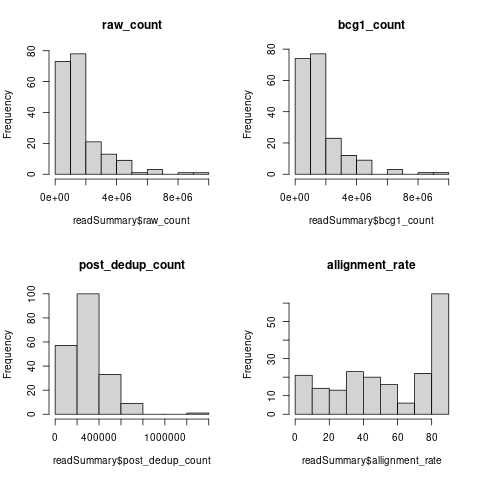

In [12]:
%%R
readSummary <- read.csv("./Output/readCountSummary.csv")
par (mfrow = c(2,2))
hist(readSummary$raw_count, main = 'raw_count')
hist(readSummary$bcg1_count, main = 'bcg1_count')
hist(readSummary$post_dedup_count, main = 'post_dedup_count')
hist(readSummary$allignment_rate, main = 'allignment_rate')

Convert sam files to bam files as input for ANGSD using Samtools

In [139]:
%%time
%%bash
cd Data
>s2b
for file in *.sam; do
echo "samtools sort -O bam -o ${file/.sam/}.bam $file && samtools index ${file/.sam/}.bam">>s2b;
done
bash s2b

CPU times: user 6.31 ms, sys: 3.61 ms, total: 9.92 ms
Wall time: 1min 47s


### Genotype calling with ANGSD

In [32]:
%%time
%%capture angsd_geno_likely
%%bash
# Fuzzy genotyping
cd Data
ls *.bam > bams
angsd -b bams -gl 2 -domajorminor 1 -snp_pval 1e-6 -domaf 1 -minmaf 0.05 -doGlf 3 -uniqueOnly 1 -remove_bads 1 -minMapQ 20 -minQ 25 -minInd 150 -out geno_likely
mv geno_likely* ../Output

CPU times: user 28 ms, sys: 7.77 ms, total: 35.7 ms
Wall time: 2min 14s


In [33]:
%%time
%%capture angsd_geno_call
%%bash
# Calling genotypes
cd Data
angsd -b bams -gl 2 -domajorminor 1 -snp_pval 1e-6 -domaf 1 -minmaf 0.05 -doGlf 3 -uniqueOnly 1 -remove_bads 1 -minMapQ 20 -minQ 25 -minInd 150 -doCounts 1 -doDepth 1 -dumpCounts 2 -doPost 1 -doGeno 4 -postCutoff 0.6 -out geno_call
mv geno_call* ../Output

CPU times: user 32.6 ms, sys: 293 µs, total: 32.9 ms
Wall time: 2min 26s


In [204]:
def getANGSDresults(fileName, excludeZero):
    df = pd.read_table(fileName, header=None)
    df.drop(101,axis=1,inplace=True)
    if excludeZero:
        df.drop(0, axis=1, inplace=True)
    df['count_depth'] = df[list(df.columns)].sum(axis=1)
    df['sumProduct'] = 0
    for i in list(df.columns):
        if type(i) == int:
            df['sumProduct'] += df[i].multiply(i)
    df['average_depth'] = df['sumProduct'] / df['count_depth']
    
    def median(row):
        row = row.iloc[0:100]
        row = list(row)
        n = sum(row)
        position = 0
        i = 0
        while position < n//2:
            position += row[i]
            i += 1
        return i 
   
    df['median_depth'] = df.apply(lambda row: median(row), axis=1)

    
    print(df['average_depth'].describe().round(2))
    weightedAverage = sum(df['average_depth'] * df['count_depth']) / sum(df['count_depth'])
    print('Weighted average: ', weightedAverage)
    sns.histplot(data=df, x = 'average_depth', fill=False)
    plt.axvline(df['average_depth'].median(), color='green', linestyle='dashed')
    plt.axvline(df['average_depth'].mean(), color='red', linestyle='dashed')
    display(df)
    df[['count_depth','average_depth','median_depth']].to_csv('./Output/coverageSummary.csv', index=False)

count    200.00
mean       8.29
std        4.62
min        1.84
25%        4.61
50%        7.88
75%       10.73
max       30.62
Name: average_depth, dtype: float64
Weighted average:  9.10367442449871


,1,2,3,4,5,6,7,8,9,10,...,95,96,97,98,99,100,count_depth,sumProduct,average_depth,median_depth
0,42,64,96,141,139,162,166,143,158,164,...,0,0,0,0,0,40,3376,51975,15.395438,13
1,93,145,200,228,248,238,205,200,216,186,...,0,0,0,0,0,28,3339,38315,11.474993,9
2,425,425,442,353,317,207,173,140,114,98,...,1,1,0,0,0,13,3147,19840,6.304417,4
3,81,131,127,169,160,172,175,191,159,148,...,0,0,0,0,0,26,3377,49906,14.778206,12
4,27,28,58,110,125,140,174,146,155,152,...,1,2,0,0,0,26,3381,57567,17.026619,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,506,469,419,296,236,175,166,110,98,69,...,0,0,0,0,0,15,2962,18729,6.323093,4
196,78,3,0,0,0,5,0,0,0,0,...,0,0,0,0,0,1,87,214,2.459770,1
197,768,595,380,288,167,124,59,74,39,38,...,0,1,0,0,0,11,2714,13267,4.888357,2
198,126,23,9,0,0,0,1,0,0,0,...,0,0,0,0,0,1,165,694,4.206061,1


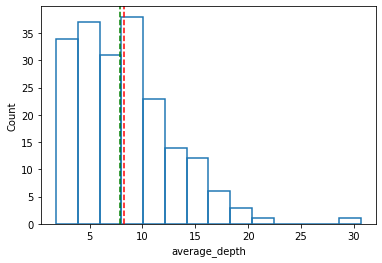

In [205]:
getANGSDresults("./Output/geno_call.depthSample", True)

Mean depth = 8.29 (weighted = 9.1). 

### NGSRelate

In [36]:
%%bash
zcat Output/geno_likely.mafs.gz | cut -f5 | sed 1d>Output/allele_freq

In [11]:
%%time
%%capture ngsRelate
%%bash
cd Data
ngsRelate -f ../Output/allele_freq -g ../Output/geno_likely.glf.gz -n 200 -z bams -O ../Output/ngsOutput.res

CPU times: user 9.39 ms, sys: 1.97 ms, total: 11.4 ms
Wall time: 39.2 s


The following function formats the NgsRelate output. It creates identifier columns (sample ID, sample number, family, mother?, child?, and replicate?) to help with easier subsetting and analysis down the road.

In [67]:
%%R
formatNGS <- function(outputFileName, wellPlateFileName){
    ngs_out <- read.table(outputFileName, header=TRUE)
    well <- read.csv(wellPlateFileName, header=TRUE)
    colnames(ngs_out)[3] <- "file_a"
    colnames(ngs_out)[4] <- "file_b"
    
    # Keep only columns we care about
    ngs_out <- subset(ngs_out, select = c(1:5, 15:20, 25, 31:33))
   
    # Create sampleID columns from file name for easier identification 
    sample.ID.A <- unlist(lapply(strsplit(ngs_out$file_a, "_" ), function(x) {paste(x[[2]], substr(x[[6]],1,4), sep ="_")}))
    ngs_out$sample.ID.A <- sample.ID.A
    
    sample.ID.B <- unlist(lapply(strsplit(ngs_out$file_b, "_" ), function(x) {paste(x[[2]], substr(x[[6]],1,4), sep ="_")}))
    ngs_out$sample.ID.B <- sample.ID.B
    
    # Joining sample ID with sample number
    ngs_out <- merge(ngs_out, well, by.x ="sample.ID.A", by.y="Sample.ID")
    colnames(ngs_out)[length(ngs_out)] <- "sample.num.A"
    
    ngs_out <- merge(ngs_out, well, by.x ="sample.ID.B", by.y="Sample.ID")
    colnames(ngs_out)[length(ngs_out)] <- "sample.num.B"
    
    # Reinstate ordering
    ngs_out <- ngs_out %>% select(sample.ID.A, everything())
    ngs_out <- ngs_out[order(ngs_out$a, ngs_out$b),]
    
    # Adding family columns
    findFamily <- function(sampleID){
        family = ''
        for (char in strsplit(sampleID,"")[[1]]){
            if (!is.na(as.numeric(char))){
                family = paste(family, char, sep = '')}
            else{break}}
        return (family)}
        
    ngs_out$family.A <- unlist(lapply(ngs_out$sample.num.A, function(x) {findFamily(x)}))    
    ngs_out$family.B <- unlist(lapply(ngs_out$sample.num.B, function(x) {findFamily(x)}))
    
    # Adding mother columns
    findMother <- function(x){
        for (char in strsplit(x, "")[[1]]){
            if (is.na(as.numeric(char)) & !grepl(char, ' replic.')) {
                return (FALSE)}}
        return (TRUE) }
    
    ngs_out$mother.A <- unlist(lapply(ngs_out$sample.num.A, function(x) {findMother(x)}))
    ngs_out$mother.B <- unlist(lapply(ngs_out$sample.num.B, function(x) {findMother(x)}))
    
    # Adding child columns
    ngs_out$child.A <- unlist(lapply(ngs_out$mother.A, function(x) {!x}))
    ngs_out$child.B <- unlist(lapply(ngs_out$mother.B, function(x) {!x}))
    
    # Adding replicate columns
    ngs_out$replic.A <- unlist(lapply(ngs_out$sample.num.A, function(x){grepl(' replic.', x)}))
    ngs_out$replic.B <- unlist(lapply(ngs_out$sample.num.B, function(x){grepl(' replic.', x)}))
    
    # Adding coverage depth median/average statistics
    cov <- read.csv('./Output/coverageSummary.csv',header=TRUE)
    ngs_out <- merge(ngs_out, cov, by.x='a',by.y='row.names')
    ngs_out <- merge(ngs_out, cov, by.x='b',by.y='row.names')
    return (ngs_out)

  
}

In [68]:
%%R
ngs <- formatNGS('Output/ngsOutput.res','SampleData/well_plate.csv')
str(ngs)

'data.frame':	19701 obs. of  33 variables:
 $ b                     : int  2 3 3 4 4 4 5 5 5 5 ...
 $ a                     : int  1 1 2 1 2 3 3 1 4 2 ...
 $ sample.ID.A           : chr  "S1_AGAC" "S1_AGAC" "S1_AGTG" "S1_AGAC" ...
 $ sample.ID.B           : chr  "S1_AGTG" "S1_CATC" "S1_CATC" "S1_CTAC" ...
 $ file_a                : chr  "ILL-RAD01_S1_L001_R1_001_AGAC.trim.bt2.bam" "ILL-RAD01_S1_L001_R1_001_AGAC.trim.bt2.bam" "ILL-RAD01_S1_L001_R1_001_AGTG.trim.bt2.bam" "ILL-RAD01_S1_L001_R1_001_AGAC.trim.bt2.bam" ...
 $ file_b                : chr  "ILL-RAD01_S1_L001_R1_001_AGTG.trim.bt2.bam" "ILL-RAD01_S1_L001_R1_001_CATC.trim.bt2.bam" "ILL-RAD01_S1_L001_R1_001_CATC.trim.bt2.bam" "ILL-RAD01_S1_L001_R1_001_CTAC.trim.bt2.bam" ...
 $ nSites                : int  3373 3638 3413 3645 3413 3686 3683 3647 3690 3410 ...
 $ rab                   : num  0.008608 0.007126 0.298146 0.028358 0.000039 ...
 $ Fa                    : num  0.01408 0.023138 0 0.035564 0.000002 ...
 $ Fb                

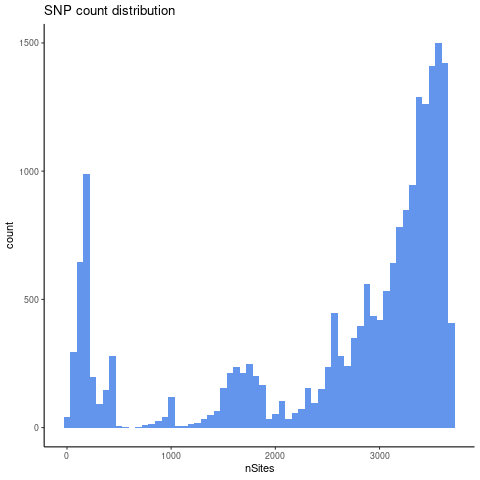

In [69]:
%%R
ggplot(ngs, aes(x=nSites)) +
    geom_histogram(bins = 60, fill = 'cornflowerblue') +
    theme_classic() +
    ggtitle("SNP count distribution") 

Skewed left with a spike at around 200 SNPs. 

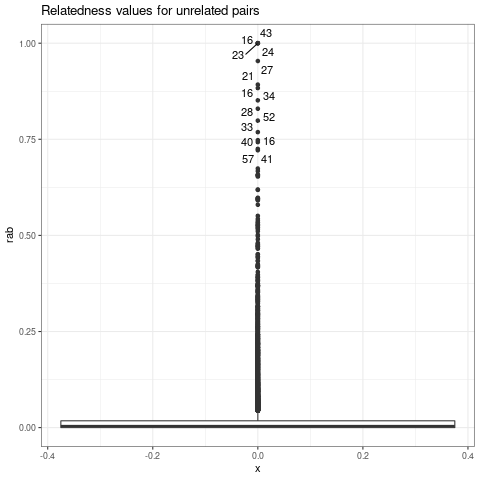

In [70]:
%%R
unrelated <- ngs %>% filter(family.A != family.B)
outliers <- unrelated %>% filter(rab > 0.16)
ggplot(unrelated, aes(y=rab)) + 
    geom_boxplot() +
    geom_text_repel(data=outliers, aes(x=0,label=nSites)) +
    theme_bw() +
    ggtitle("Relatedness values for unrelated pairs")

Median is around 0, as we would expect, but many outliers with high relatedness (all with relatively low quantity of site comparisons).

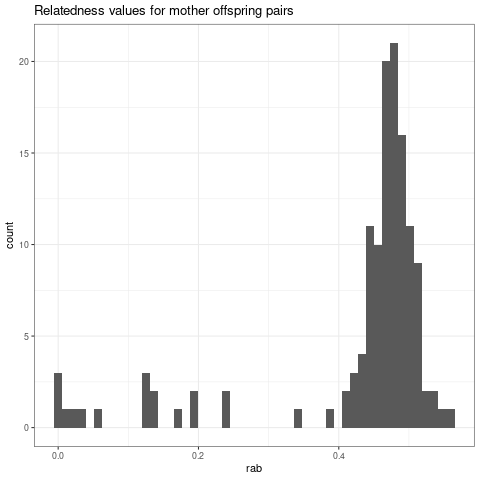

In [71]:
%%R
ggplot(ngs %>% filter(family.A == family.B & mother.A + mother.B == 1 & replic.A + replic.B == 0), 
       aes(x=rab)) +
    geom_histogram(bins=50) +
    theme_bw() +
    ggtitle("Relatedness values for mother offspring pairs")

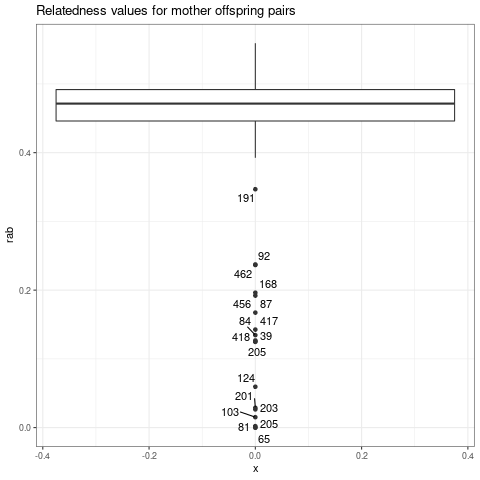

In [72]:
%%R
outliers <- ngs %>% filter(family.A == family.B & mother.A + mother.B == 1 & replic.A + replic.B == 0) %>% filter(rab<0.38 | rab > 0.6)
ggplot(ngs %>% filter(family.A == family.B & mother.A + mother.B == 1 & replic.A + replic.B == 0), 
       aes(y=rab)) + 
    geom_boxplot() +
    geom_text_repel(data=outliers, aes(x=0,label=nSites)) +
    theme_bw() +
    ggtitle("Relatedness values for mother offspring pairs")

Median ~0.5 as we expect, but large number of pairs with low relatedness, all with relatively low quantity of sites (<500)

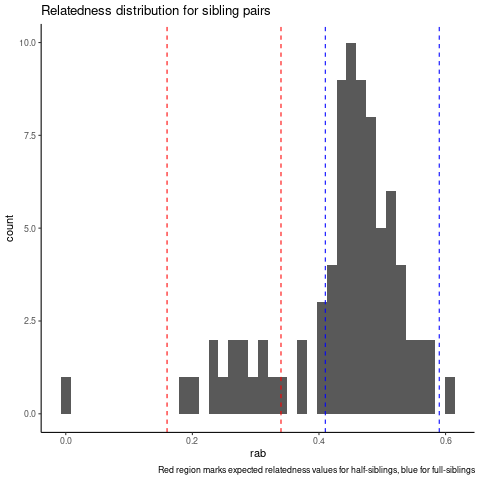

In [73]:
%%R
sibPairs <- ngs %>% filter(family.A==family.B & child.A + child.B ==2 & replic.A+replic.B ==0)
ggplot(sibPairs, aes(x=rab)) + 
    geom_histogram(bins=40) + 
    theme_classic() + 
    geom_vline(xintercept = 0.16, linetype = 'dashed', color='red') +
    geom_vline(xintercept = 0.34, linetype = 'dashed', color='red') +
    geom_vline(xintercept = 0.41, linetype = 'dashed', color='blue') +
    geom_vline(xintercept = 0.59, linetype = 'dashed', color='blue') +
    ggtitle("Relatedness distribution for sibling pairs") + 
    labs(caption = "Red region marks expected relatedness values for half-siblings, blue for full-siblings")
    

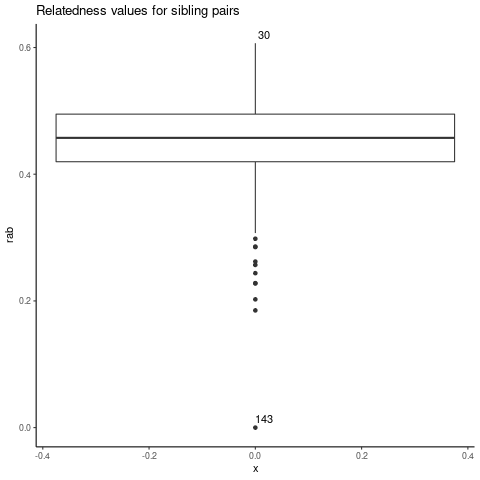

In [74]:
%%R
outliers <- sibPairs %>% filter(rab<0.16 | rab > 0.59)
ggplot(sibPairs, aes(y=rab)) + 
    geom_boxplot() +
    geom_text_repel(data=outliers, aes(x=0,label=nSites)) +
    theme_classic() +
    ggtitle("Relatedness values for sibling pairs")

### Outlier investigation: 17A / 17B

By filtering to nSites equals 143, we find that the outlier with low relatedness are supposed siblings 17A and 17B.

In [75]:
%%R
print(sibPairs %>% filter (nSites == 143))

   b  a sample.ID.A sample.ID.B                                     file_a
1 98 43     S4_GTGA     S9_AGTG ILL-RAD04_S4_L001_R1_001_GTGA.trim.bt2.bam
                                      file_b nSites rab Fa      Fb theta
1 ILL-RAD09_S9_L001_R1_001_AGTG.trim.bt2.bam    143   0  0 6.3e-05     0
  inbred_relatedness_1_2 inbred_relatedness_2_1 F_diff_a_b       R0       R1
1                      0                      0   -3.1e-05 0.292035 0.345635
      KING sample.num.A sample.num.B family.A family.B mother.A mother.B
1 0.090396          17B          17A       17       17    FALSE    FALSE
  child.A child.B replic.A replic.B count_depth.x average_depth.x
1    TRUE    TRUE    FALSE    FALSE          3259        7.819577
  median_depth.x count_depth.y average_depth.y median_depth.y
1              6          3121        5.902595              4


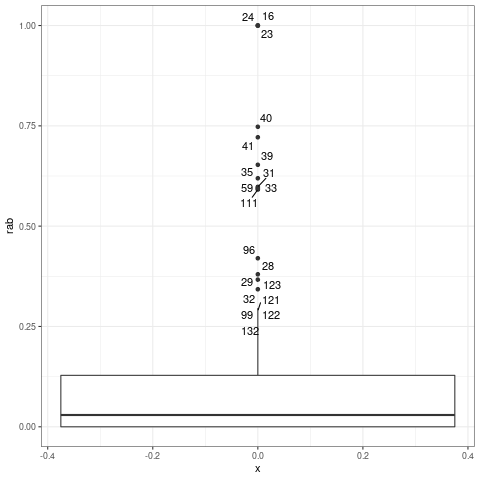

In [76]:
%%R
pairs.17A <- ngs %>% filter(sample.num.A == '17A' | sample.num.B == '17A')
ggplot(pairs.17A, aes(y=rab)) + 
    geom_boxplot() + 
    geom_text_repel(data=pairs.17A %>% filter(rab > 0.25), aes(x=0,label=nSites)) + theme_bw()

Many inviduals with high relatedness to 17A, all have relatively low SNP count (16-132). 17A likely has poor sequence quality.

In [77]:
%%R
sampleQuality <- read.csv("./Output/readCountSummary.csv")
sample17A.quality <- sampleQuality %>% filter(Sample.Number == '17A')
sample17A.quality

       ID raw_count bcg1_count post_dedup_count post_filt_count  reads
1 S9_AGTG   1916960    1879736           200420          200420 200420
  allignment_rate Sample.Number raw_count_Z bcg1_count_Z post_dedup_count_Z
1            0.88           17A   0.1803085    0.1848701         -0.5799924
  post_filt_count_Z    reads_Z allignment_rate_Z
1        -0.5799923 -0.5799923         -1.827836


17A has below average reads/allignment rates (Z-scores: Z = -0.5799923, Z = -1.827836)

Perhaps 17A was mislabeled and belongs to another family. Checking to see if there are any other potential families that sample 17A reasonably could fall into where the relatedness between 17A and potential siblings is greater than 0.2, and the relatedness between 17A and potential mother is greater than 0.4.

In [78]:
%%R
potentialSibs.17A <- pairs.17A %>% filter(child.A + child.B ==2 & rab > 0.2)
potentialMothers.17A <- pairs.17A %>% filter(child.A + child.B ==1 & rab > 0.4)

possibleFams.17A <- intersect(union(potentialSibs.17A$family.A,potentialSibs.17A$family.B),
                                union(potentialMothers.17A$family.A, potentialMothers.17A$family.B))

print(possibleFams.17A)


[1] "17" "28"


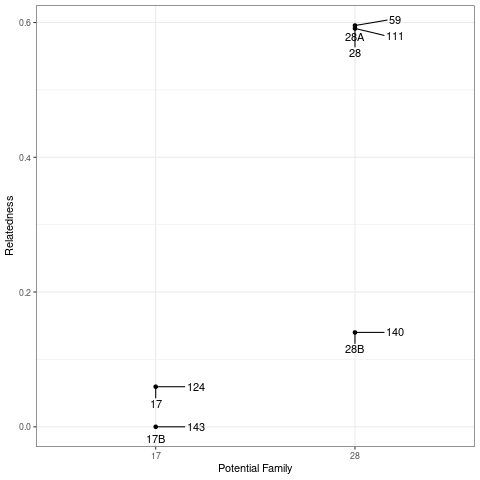

In [79]:
%%R
# Only potential family identified is 28.
potentialFams.17A <- pairs.17A %>% filter ((family.A %in% c("17","28") & 
                                            (family.B %in% c("17","28"))))
potFamily <- function(x,y){
    if (x=='17'){return (y)}else{return (x)}}

otherID <- function(x,y){
    if (x=='17A'){return(y)} else{return(x)}}
potentialFams.17A$pot.fam <- mapply(potFamily, potentialFams.17A$family.A, potentialFams.17A$family.B )
potentialFams.17A$otherID <- mapply(otherID, potentialFams.17A$sample.num.A, potentialFams.17A$sample.num.B)

ggplot(data = potentialFams.17A, aes(y = rab, x = pot.fam)) + 
    theme_bw() +
    geom_point() +
    geom_text_repel(aes(x=pot.fam, label=nSites), nudge_x=0.2) + 
    geom_text_repel(aes(x=pot.fam, label=otherID), nudge_y=-0.025) + 
    ylab("Relatedness") + 
    xlab("Potential Family")

Family 28 is the only family that meets these criteria. Lets assume 17A and 28A could be full siblings and 17A and 28B are half siblings (their rab is about 0.16). This implies that 28A and and 28B are also half siblings. Is this likely?

In [80]:
%%R
sibs.28 <- sibPairs %>% filter(sample.num.A == '28B' & sample.num.B == '28A')
print(sibs.28$rab)

[1] 0.456836


28A and 28B are likely full siblings (rab = 0.46). Our conclusion is that 17A was not misabled but rather suffers from poor read quality.

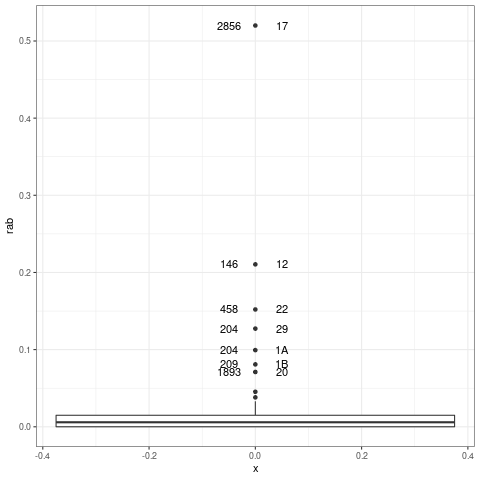

In [81]:
%%R
# A quick look at 17B
pairs.17B <- ngs %>% filter(sample.num.A == '17B' | sample.num.B == '17B')
ggplot(pairs.17B, aes(y=rab)) + 
    geom_boxplot() + 
    geom_text(data=pairs.17B %>% filter(rab > 0.05), aes(x=0,label=nSites), nudge_x=-0.05) + 
    geom_text(data=pairs.17B %>% filter(rab > 0.05), aes(x=0,label=sample.num.B), nudge_x=0.05) +
    theme_bw()

17B has expected relatedness with mother, and we are very confident in this value (# SNPs = 2856). It is very likely that 17B was not mislabeled.

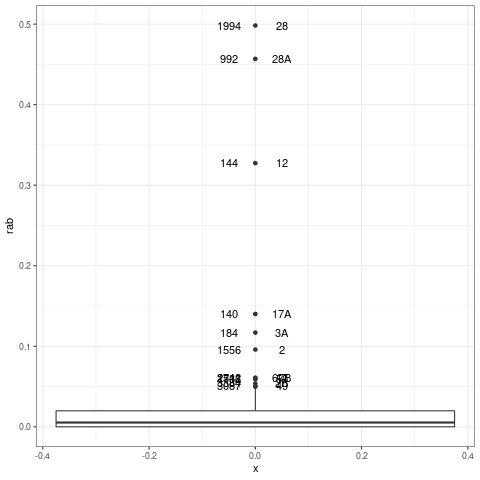

In [82]:
%%R
pairs.28B <- ngs %>% filter(sample.num.A == '28B' | sample.num.B == '28B')
ggplot(pairs.28B, aes(y=rab)) + 
    geom_boxplot() + 
    geom_text(data=pairs.28B %>% filter(rab > 0.05), aes(x=0,label=nSites), nudge_x=-0.05) + 
    geom_text(data=pairs.28B %>% filter(rab > 0.05), aes(x=0,label=sample.num.B), nudge_x=0.05) +
    theme_bw()

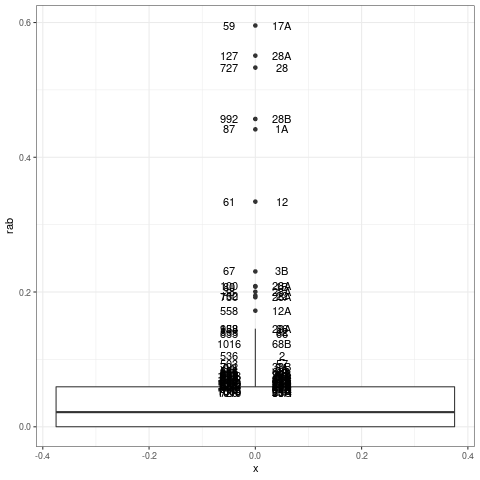

In [227]:
%%R
pairs.28A <- ngs %>% filter(sample.num.A == '28A' | sample.num.B == '28A')
ggplot(pairs.28A, aes(y=rab)) + 
    geom_boxplot() + 
    geom_text(data=pairs.28A %>% filter(rab > 0.05), aes(x=0,label=nSites), nudge_x=-0.05) + 
    geom_text(data=pairs.28A %>% filter(rab > 0.05), aes(x=0,label=sample.num.A), nudge_x=0.05) +
    theme_bw()

28B is highly related to its mother 28, so it too is likely correctly labeled.

We conclude that 17A suffers from poor sequencing/genotyping quality and was not mislabeled.

### Bootstrap Confidence Intervals

In [132]:
%%R
pairs <- data.frame(sibPairs$a, sibPairs$b)
write.table(pairs, file = 'CI/pairs.csv',sep=',',col.names=FALSE,row.names=FALSE)

In [133]:
def makeCIlaunch(frequencyFile, ANGSDglfFile, bamsFile):
    launch_pairs = open("./CI/ngs_CI_launch.sh","w")
    pairCombos = open("./CI/pairs.csv", "r")

    for line in pairCombos:
        line = line.strip()
        line=line.split(",")
        a = line[0]
        b = line[1]

        launch_pairs.write('ngsRelate -f '+frequencyFile+' -g '+ ANGSDglfFile+' -n 200 -z '+bamsFile+' -O CI/'+a+'_'+b+'_CI_output.res -a '+a+ ' -b '+b+ ' -B 10000')
        launch_pairs.write('\n')


    launch_pairs.close()

In [134]:
makeCIlaunch("Output/allele_freq",'Output/geno_likely.glf.gz','Data/bams')

In [138]:
%%time
%%capture ngsBootstrap
%%bash
bash CI/ngs_CI_launch.sh

CPU times: user 127 ms, sys: 66.8 ms, total: 193 ms
Wall time: 34min 40s


In [143]:
%%bash
cd CI
> CI_R_launch
for file in *.res; do
echo "Rscript get_CI.R $file ../Output/CI_output.csv" >> CI_R_launch;
done
> ../Output/CI_output.csv
echo "a,b,rab_lower,rab_upper,R0_lower,R0_upper,R1_lower,R1_upper" >> ../Output/CI_output.csv
bash CI_R_launch

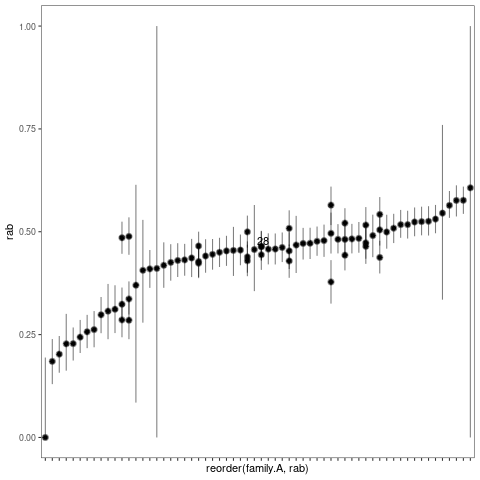

In [83]:
%%R
bootstrapCI <- read.csv('Output/CI_output.csv') 
sibPairs <- merge(sibPairs, bootstrapCI)
ggplot(sibPairs, aes(x=reorder(family.A, rab), y=rab)) +
    geom_point() + 
    theme_bw() + theme(axis.text.x = element_blank(), panel.grid.major = element_blank(), 
                       panel.grid.minor = element_blank() ) +
    geom_pointrange(aes(ymin = rab_lower, ymax = rab_upper),width=0.1, alpha = 0.5) +
    geom_text_repel(data=sibPairs%>%filter(family.A=='28'),aes(x=reorder(family.A, rab), label=family.A))


### Colony

##### Preparing Input

In [23]:
%%R
# Creating table containing information on each sample (File, ngsID, sample.num, family, ... )
sample_A <- subset(ngs, select=c(1,3,12,14,16,18,20)) # Select columns from ngs we are interested in (a)
sample_A <- sample_A[!duplicated(sample_A),] # Remove duplicate records
colnames(sample_A) <- c('sample.ID','ID','sample.num','family','mother','child','replic') # Change col names

sample_B <- subset(ngs, select=c(2,4,13,15,17,19,21)) # Repeat the same process for the 'b' records
sample_B <- sample_B[!duplicated(sample_B),]
colnames(sample_B) <- c('sample.ID','ID','sample.num','family','mother','child','replic')

sample_info <- rbind(sample_A, sample_B) # Add their rows together (stack on top of each other)
sample_info <- sample_info[!duplicated(sample_info),] # Remove duplicates
write.table(sample_info, 'SampleData/sample_info.txt', sep="\t", row.names=FALSE, col.names=TRUE, quote = FALSE ) # Write to file

In [276]:
%%R
getColonyInput <- function(ngs, genoFile, sample_info){
    ### MARKER INFO
    geno <- read.delim(genoFile, header=FALSE) # Read geno file
    geno <- subset(geno, select=c(3:202)) # Get rid of columns we don't need
    geno <- data.frame(t(geno)) # Transpose dataframe (switch columns/rows)
    rownames(geno) <- 1:200 # Change row names
 
    baseToInt <- function(x){ # Function converts nucleotide to integer
        if (x=='C'){return(1)} else if(x=='G'){return(2)}
            else if(x=='T'){return(3)} else if(x=='A'){return(4)}
                else{return(0)}}
    
    geno_new <- data.frame('index'=c(0:199)) # Create new dataframe
    for (col in colnames(geno)){ # Iterate through columns of geno dataframe
        
        col.1 = paste('mk',substr(col, 2,nchar(col)),'-1',sep='') # Make new col name ex. mk1-1
        geno_new[col.1] <- unlist(lapply(geno[,col], function(x) {baseToInt(substr(x,1,1))})) # Add column with 1st allele
        
        col.2 = paste('mk',substr(col, 2,nchar(col)),'-2',sep='') # Make other col name ex. mk1-2
        geno_new[col.2] <- unlist(lapply(geno[,col], function(x) {baseToInt(substr(x,2,2))})) # Add column with 2nd allele
    }
          
    geno <- merge(sample_info, geno_new, by.x='ID', by.y="index") # Merge with sample information
    write.table(geno, 'ColonyInput/all_geno.txt', sep="\t", row.names=FALSE, col.names=FALSE, quote = FALSE ) # write to table
           
    # Offspring subset
    geno.child <- geno %>% filter(child==TRUE, replic==FALSE) %>% subset(select=c(3, 8:6813)) # Subset
    write.table(geno.child, 'ColonyInput/offspring_geno.txt', sep="\t", row.names=FALSE, col.names=FALSE, quote = FALSE ) # write to table
    
    # Maternal subset
    geno.maternal <- geno %>% filter(mother==TRUE, replic==FALSE) %>% subset(select=c(3, 8:6813)) # Subset
    write.table(geno.maternal, 'ColonyInput/maternal_geno.txt', sep="\t", row.names=FALSE, col.names=FALSE, quote = FALSE ) # write to table
    
    # Replicates subset    
    geno.replicates <- geno %>% filter(replic==TRUE) %>% subset(select=c(3, 8:6813)) # Subset
    geno.replicates$sample.num <- unlist(lapply(geno.replicates$sample.num, function(x)  # Replace space with underscore  
        {paste(unlist(strsplit(x, " "))[1], unlist(strsplit(x, " "))[2], sep="_")}))
    sampleNumReplic <- unlist(lapply(geno.replicates$sample.num, function(x) {unlist(strsplit(x, "_"))[1]} )) # Ex. getting "43A" from "43A replic."
    geno.replicates <- rbind(geno.replicates, geno %>% filter(sample.num %in% sampleNumReplic)  %>% subset(select=c(3, 8:6813))) # Adding replicate rows.
    write.table(geno.replicates, 'ColonyInput/replicates_geno.txt', sep="\t", row.names=FALSE, col.names=FALSE, quote = FALSE ) # write to table
 
        
    ### Creating Family Structure Table (rows look like: 1 -> 1a -> 1b) i.e. mother ID followed by offsrping.
    # *NOTE: we have one instance (siblings 63A and 63B) where there is no data on the mother.
    nrows = length(geno.maternal$sample.num)
    fam_str <- data.frame(rep(NA,nrows), rep(NA,nrows), rep(NA,nrows)) # Create empty dataframe
    rownames(fam_str) <- geno.maternal$sample.num # set index equal to maternal sample numbers
    colnames(fam_str) <- c(1,2,3) # Change column names (allows for easy indexing)
    offspring <- sample_info%>%filter(mother==FALSE, replic==FALSE)%>%subset(select=c(3,4)) #Filter out mothers/replicates
        
    for (i in 1:length(offspring$family)){ # Iterate through each row in offspring table
        family = offspring$family[i] # ex. family = '1'
        sample.num = offspring$sample.num[i] #ex. sample.num = '1a'
        if (family %in% rownames(fam_str) & is.na(fam_str[family,1])){ # "If family is a valid mother ID and 1st cell in row with family is empty"
            fam_str[family,1] = sample.num # Put in sample number
        } else if (family %in% rownames(fam_str) & is.na(fam_str[family,2])){ # and so on for the next cells...
            fam_str[family,2] = sample.num
        } else if (family %in% rownames(fam_str) & is.na(fam_str[family,3])){
            fam_str[family,3] = sample.num}
    } 
     
    write.table(fam_str, "ColonyInput/family_structure.txt", sep="\t", row.names=TRUE, col.names=FALSE, na="", quote = FALSE ) # write to table       
}    

In [277]:
%%R
getColonyInput(ngs, './Output/geno_call.geno.gz', sample_info)

In [266]:
%%time
%%capture
%%bash
cd ../Programs/COLONY
./colony2s.ifort.out IFN:../../DeerProject/ColonyInput/replicates.Dat

CPU times: user 95.3 ms, sys: 7.75 ms, total: 103 ms
Wall time: 43.6 s


In [267]:
%%bash
mv ../Programs/COLONY/deerReplicates.* ColonyOutput/deerReplicates

In [268]:
replicErrorRates = pd.read_csv('ColonyOutput/deerReplicates/deerReplicates.ErrorRate')
replicErrorRates.describe().round(4)

,StartDropRate,DropRateEst,DropRateCI95LB,DropRateCI95UB,StartOtherErrorRate,OtherErrorRateEst,OtherErrorRateCI95LB,OtherErrorRateCI95UB
count,2582.00,2582.0000,2582.0000,2582.0000,2582.0000,2582.0000,2582.0000,2582.0000
mean,0.05,0.0519,0.0012,0.4291,0.0001,0.0073,0.0000,0.4827
std,0.00,0.1926,0.0133,0.2237,0.0000,0.0250,0.0000,0.2154
min,0.05,0.0000,0.0000,0.0926,0.0001,0.0000,0.0000,0.0098
25%,0.05,0.0000,0.0000,0.2430,0.0001,0.0000,0.0000,0.3197
50%,0.05,0.0000,0.0000,0.4220,0.0001,0.0000,0.0000,0.4274
75%,0.05,0.0000,0.0000,0.5062,0.0001,0.0000,0.0000,0.5877
max,0.05,1.0000,0.1675,1.0000,0.0001,0.2612,0.0002,1.0000


In [272]:
with open('ColonyInput/sibsMarkerInfo.txt','w') as markerFile:
    markerFile.write('mk@\n')
    markerFile.write('0@\n')
    markerFile.write(replicErrorRates['DropRateEst'].mean().round(4).astype('str') + '@\n')
    markerFile.write(replicErrorRates['OtherErrorRateEst'].mean().round(4).astype('str') + '@\n')

COLONY run for sibship inferences using estimated average alleic dropout rate and other error rate from replicates.

In [109]:
%%capture ColonySibs1
%%time
%%bash
cd ../Programs/COLONY
./colony2s.ifort.out IFN:../../DeerProject/ColonyInput/sibs.Dat

In [110]:
%%bash
mv ../Programs/COLONY/deerSibs.* ColonyOutput/deerSibs

COLONY run for sibship inferences using loci specific error rates from inferred pedigree.

In [111]:
%%R
error_rates <- read.csv("./ColonyOutput/deerSibs/deerSibs.ErrorRate")
error_rates$dominance = 0
error_rates$OtherErrorRateEst <- sapply(error_rates$OtherErrorRateEst, function(x){if (x==0){return(0.0001)}else{return(x)}})
error_rates <- t(error_rates[,c(1,10,3,7)])
write.table(error_rates, "ColonyInput/sibs2MarkerInfo.txt", sep="\t", row.names=FALSE, col.names=FALSE, quote = FALSE )

In [12]:
%%time
%%capture ColonySibs2
%%bash
cd ../Programs/COLONY
./colony2s.ifort.out IFN:../../DeerProject/ColonyInput/sibs2.Dat

CPU times: user 27.3 s, sys: 4.02 s, total: 31.3 s
Wall time: 2h 38min 16s


In [15]:
%%bash
mv ../Programs/COLONY/deerSibs2.* ColonyOutput/deerSibs2

### Results

In [84]:
%%R
halfSibDyad <- read.csv('ColonyOutput/deerSibs2/deerSibs2.HalfSibDyad') # Read in COLONY output for half sibs
colnames(halfSibDyad)[3] <- 'Prob.Half' # Change column name
fullSibDyad <- read.csv('ColonyOutput/deerSibs2/deerSibs2.FullSibDyad') # Read in COLONY output for full sibs
colnames(fullSibDyad)[3] <- 'Prob.Full' # Change column name
# Merge fullSib and halfSib dataframes 
Sib.Pairs <- merge(halfSibDyad, fullSibDyad, by.x= c('OffspringID1','OffspringID2'), by.y = c('OffspringID1','OffspringID2'), all.x =TRUE, all.y = TRUE )
Sib.Pairs[is.na(Sib.Pairs)] <- 0 # Replace NAs with 0s
sibAssignFunc <- function(x,y){if (x>0.95){return("Half")} else if(y>0.95){return("Full")} else{return('Unknown')}} # 0.95 is our probability cutoff
Sib.Pairs$assignment <- mapply(sibAssignFunc, Sib.Pairs$Prob.Half, Sib.Pairs$Prob.Full ) # Apply previous function to our half/full probabilities

findFamily <- function(sampleID){ # Function that inputs sample ID and outputs family. Ex. '10A' -> '10'
        family = ''
        for (char in strsplit(sampleID,"")[[1]]){
            if (!is.na(as.numeric(char))){
                family = paste(family, char, sep = '')}
            else{break}}
        return (family)}


removeNonFam <- function(x,y){return(findFamily(x)==findFamily(y))} # Returns true if familes are the same. Ex. (10A, 10B) -> TRUE
Sib.Pairs$Same.Family <- mapply(removeNonFam, Sib.Pairs$OffspringID1, Sib.Pairs$OffspringID2) # Applies previous function to our dataframe
Sib.Pairs <- Sib.Pairs[Sib.Pairs$Same.Family,] # Remove entries that are not of the same family
head(Sib.Pairs) # Display results

  OffspringID1 OffspringID2 Prob.Half Prob.Full assignment Same.Family
1          10A          10B     0.000     1.000       Full        TRUE
2          11A          11B     0.000     1.000       Full        TRUE
4          12B          12A     0.693     0.307    Unknown        TRUE
6          13A          13B     1.000     0.000       Half        TRUE
7          14B          14A     1.000     0.000       Half        TRUE
8          15A          15B     1.000     0.000       Half        TRUE


In [85]:
%%R
sibPairs <- left_join(sibPairs, Sib.Pairs, by = c('sample.num.A' = 'OffspringID1', 'sample.num.B' = 'OffspringID2'))

R[write to console]: Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



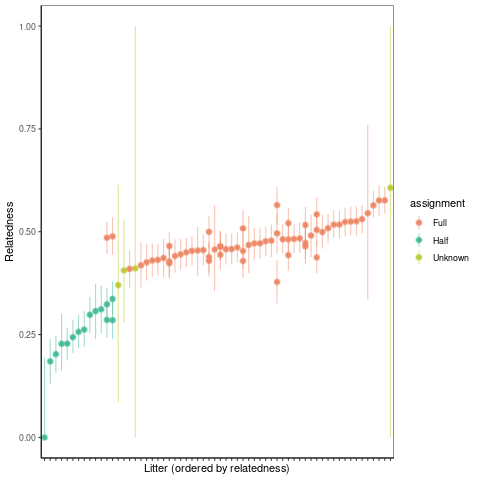

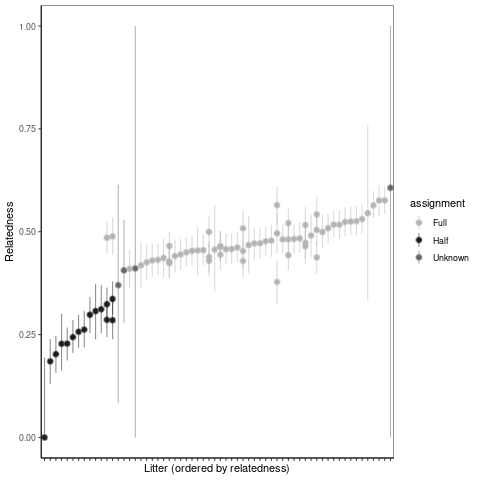

In [86]:
%%R
p1 <- ggplot(sibPairs, aes(x=reorder(family.A, rab), y=rab, color=assignment)) +
    geom_point() + 
    theme_bw() + 
    theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          panel.background = element_blank(), axis.line = element_line(colour = "black"), 
          axis.text.x = element_blank(),
          plot.caption.position = "plot",
          plot.caption = element_text(hjust = 0)) +
    geom_pointrange(aes(ymin = rab_lower, ymax = rab_upper),width=0.1, alpha = 0.5) +
    labs(color='assignment') +  
    xlab("Litter (ordered by relatedness)") +
    ylab("Relatedness") +
    scale_color_manual(values=c("#EE8866", "#44BB99", "#BBCC33"))

p2 <- p1 + scale_color_manual(values=c("grey70", "grey10", "grey40"))
print(p1)
print(p2)

In [87]:
%%R
family <- unlist(lapply(Sib.Pairs$OffspringID1, function(x){findFamily(x)}))
familyUnique <- unique(family)
familyAssignments <- data.frame(rep(0,length(familyUnique)))
colnames(familyAssignments) <- c("Evd.Of.Mult.Pat")
rownames(familyAssignments) <- familyUnique
for (i in 1:length(Sib.Pairs$OffspringID1)){
    family = findFamily(Sib.Pairs$OffspringID1[i])
    if (Sib.Pairs$assignment[i] == 'Half'){
        familyAssignments[family, 1] = 1
    }
    else if (Sib.Pairs$assignment[i] == 'Unknown'){
        familyAssignments[family, 1] = 'Unknown'
    }
}

In [88]:
%%R
known <- familyAssignments %>% filter(Evd.Of.Mult.Pat != 'Unknown')
mean(as.numeric(known$Evd.Of.Mult.Pat))

[1] 0.2241379


In [89]:
%%R
familyAssignments

   Evd.Of.Mult.Pat
10               0
11               0
12         Unknown
13               1
14               1
15               1
16               0
17               1
1          Unknown
20               0
21               0
22               0
24               0
26               0
27               0
28               0
29               1
2                1
30               0
31               0
32               0
33               0
34               0
35               0
36               1
37               1
38               0
39               0
3          Unknown
40               0
41               0
42               0
43               0
44               1
45               1
46               0
47               0
48               0
49               0
4                0
50               0
51               1
52               0
53               0
54               0
55               0
56               0
57               0
58               0
59               0
5                0
60          

In [90]:
%%R
table(familyAssignments$Evd.Of.Mult.Pat)


      0       1 Unknown 
     45      13       4 


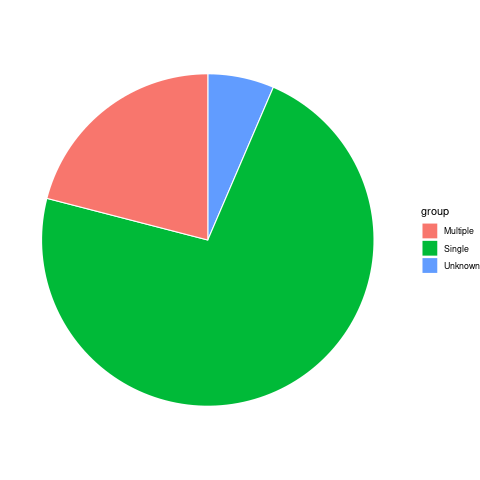

In [91]:
%%R
pieDist <- data.frame(group=c('Unknown','Single','Multiple'), value=c(4,45,13))
ggplot(pieDist, aes(x='', y=value, fill=group)) + 
    geom_bar(stat="identity",width=1,color='white') + 
    coord_polar('y',start=0) +
    theme_void()

### SNP distribution for sibling pairs

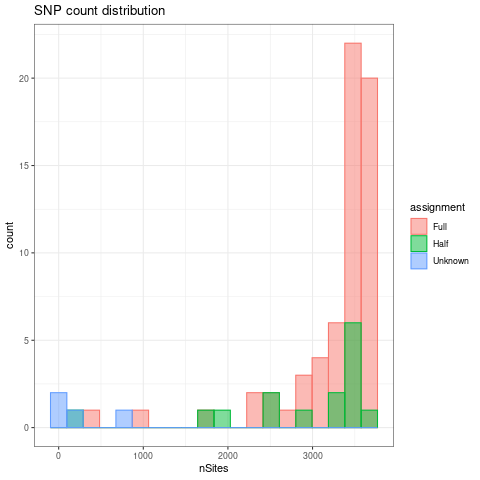

In [92]:
%%R
ggplot(sibPairs, aes(x=nSites, fill = assignment, color = assignment)) +
    geom_histogram(bins = 20, position='identity', alpha=0.5) +
    theme_bw() +
    ggtitle("SNP count distribution")

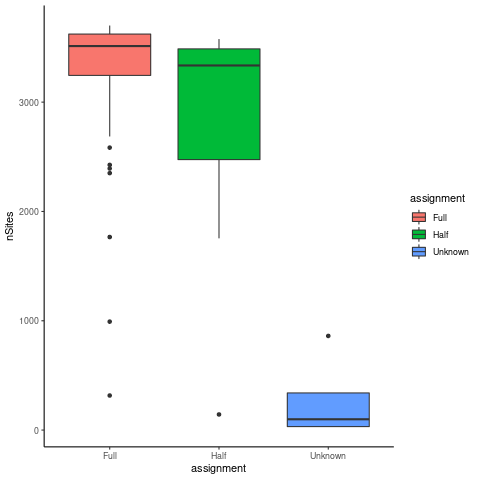

In [47]:
%%R
ggplot(sibPairs, aes(x=assignment, y=nSites, fill=assignment)) +
  geom_boxplot() +
  theme_classic()


### Coverage depth for sibling pairs

In [93]:
%%R 
sibPairs$min_med_depth <- mapply(function(x,y){return(min(x,y))},sibPairs$median_depth.x, sibPairs$median_depth.y)
sibPairs$min_avg_depth <- mapply(function(x,y){return(min(x,y))},sibPairs$average_depth.x, sibPairs$average_depth.y)
sibPairs$avg_med_depth <- mapply(function(x,y){return(mean(c(x,y)))},sibPairs$median_depth.x, sibPairs$median_depth.y)
sibPairs$avg_avg_depth <- mapply(function(x,y){return(mean(c(x,y)))},sibPairs$average_depth.x, sibPairs$average_depth.y)

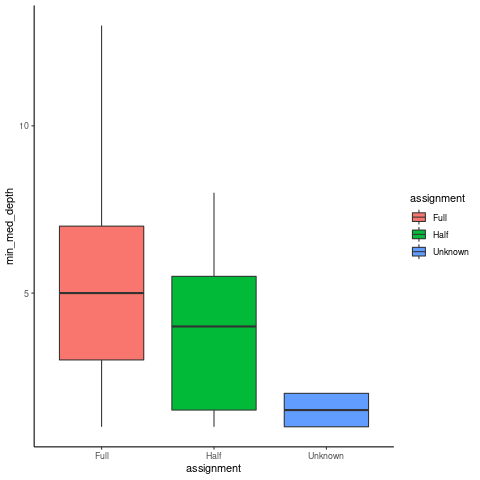

In [49]:
%%R
ggplot(sibPairs, aes(x=assignment, y=min_med_depth, fill=assignment)) + 
    geom_boxplot() +
    theme_classic()

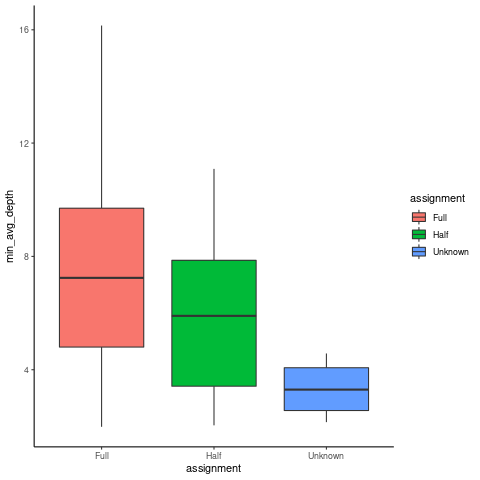

In [50]:
%%R
ggplot(sibPairs, aes(x=assignment, y=min_avg_depth, fill=assignment)) + 
    geom_boxplot() +
    theme_classic()

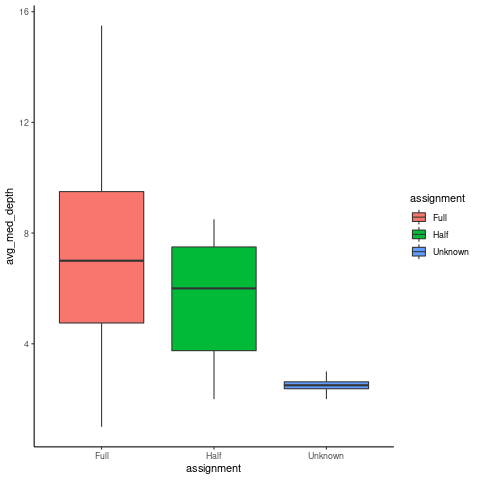

In [51]:
%%R
ggplot(sibPairs, aes(x=assignment, y=avg_med_depth, fill=assignment)) + 
    geom_boxplot() +
    theme_classic()

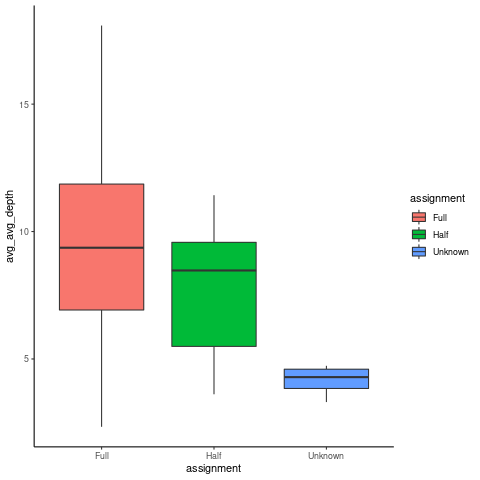

In [52]:
%%R
ggplot(sibPairs, aes(x=assignment, y=avg_avg_depth, fill=assignment)) + 
    geom_boxplot() +
    theme_classic()

In [94]:
%%R
sibPairsKnown <- sibPairs %>% filter(assignment != 'Unknown')
readQualityLogit <- glm(factor(assignment) ~ avg_med_depth + nSites + nSites * avg_med_depth, data= sibPairsKnown, family='binomial')
summary(readQualityLogit)


Call:
glm(formula = factor(assignment) ~ avg_med_depth + nSites + nSites * 
    avg_med_depth, family = "binomial", data = sibPairsKnown)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4677  -0.6703  -0.5222  -0.2983   2.1541  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)
(Intercept)          -3.1793366  3.1268759  -1.017    0.309
avg_med_depth         0.7870571  0.6002302   1.311    0.190
nSites                0.0008185  0.0010185   0.804    0.422
avg_med_depth:nSites -0.0002847  0.0001873  -1.520    0.129

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 76.370  on 77  degrees of freedom
Residual deviance: 68.601  on 74  degrees of freedom
AIC: 76.601

Number of Fisher Scoring iterations: 5



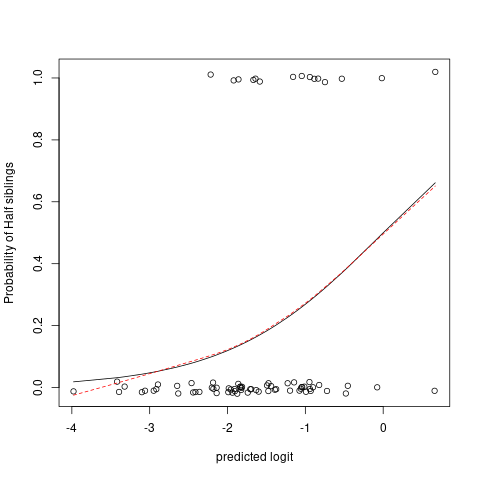

In [54]:
%%R
predpr = predict(readQualityLogit, type='response')
predlogit = predict(readQualityLogit)
plot(jitter(ifelse(sibPairsKnown$assignment=='Half',1,0),0.1) ~ predlogit, 
xlab='predicted logit', ylab="Probability of Half siblings")
pred.ord = order(predlogit)
lines(predlogit[pred.ord], predpr[pred.ord])
lines (lowess(predlogit[pred.ord],predpr [pred.ord]), col='red',lty=2)

### Relatedness for sibling pairs

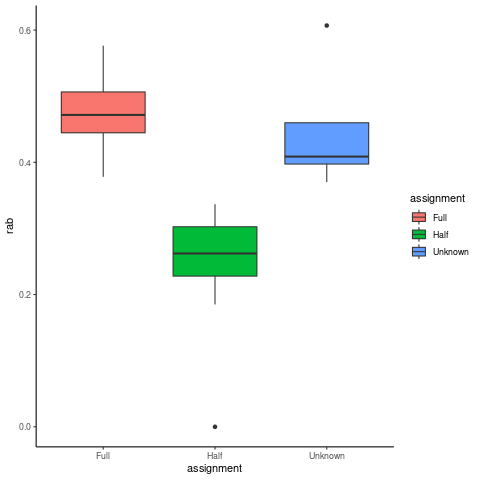

In [55]:
%%R
ggplot(sibPairs, aes(x=assignment, y=rab, fill=assignment)) + 
    geom_boxplot() +
    theme_classic()

In [56]:
%%R
t.test(rab ~ assignment, data=sibPairsKnown)


	Welch Two Sample t-test

data:  rab by assignment
t = 10.327, df = 15.843, p-value = 1.93e-08
alternative hypothesis: true difference in means between group Full and group Half is not equal to 0
95 percent confidence interval:
 0.1800790 0.2732057
sample estimates:
mean in group Full mean in group Half 
         0.4769129          0.2502705 



### Comparing Mother, Offspring relatedness between mult. pat and non mult. pat groups

In [95]:
%%R
motherOffspring <- ngs %>% filter(family.A == family.B & mother.A + mother.B == 1 & replic.A + replic.B == 0)
motherOffspring <- merge(motherOffspring, familyAssignments, by.x='family.A', by.y='row.names')
motherOffspring <- motherOffspring %>% filter(nSites > 500)
str(motherOffspring)

'data.frame':	112 obs. of  34 variables:
 $ family.A              : chr  "10" "10" "11" "11" ...
 $ b                     : int  97 122 160 160 142 142 72 126 91 94 ...
 $ a                     : int  25 97 123 127 74 130 14 72 87 87 ...
 $ sample.ID.A           : chr  "S3_AGAC" "S9_AGAC" "S11_CATC" "S11_GTGA" ...
 $ sample.ID.B           : chr  "S9_AGAC" "S11_AGTG" "S14_CTAC" "S14_CTAC" ...
 $ file_a                : chr  "ILL-RAD03_S3_L001_R1_001_AGAC.trim.bt2.bam" "ILL-RAD09_S9_L001_R1_001_AGAC.trim.bt2.bam" "ILL-RAD11_S11_L001_R1_001_CATC.trim.bt2.bam" "ILL-RAD11_S11_L001_R1_001_GTGA.trim.bt2.bam" ...
 $ file_b                : chr  "ILL-RAD09_S9_L001_R1_001_AGAC.trim.bt2.bam" "ILL-RAD11_S11_L001_R1_001_AGTG.trim.bt2.bam" "ILL-RAD14_S14_L001_R1_001_CTAC.trim.bt2.bam" "ILL-RAD14_S14_L001_R1_001_CTAC.trim.bt2.bam" ...
 $ nSites                : int  3361 2991 3457 3462 3280 3091 3570 3552 3389 3359 ...
 $ rab                   : num  0.474 0.494 0.458 0.458 0.511 ...
 $ Fa           

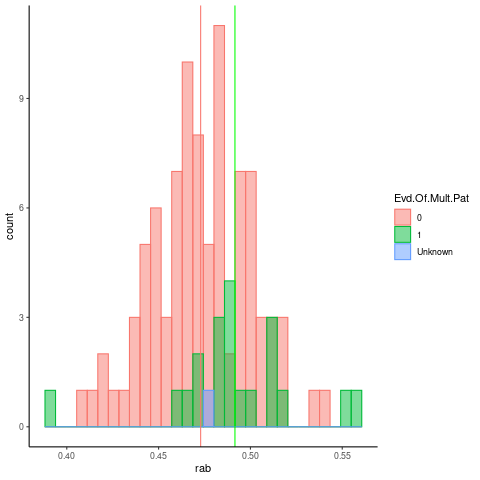

In [58]:
%%R
ggplot(data=motherOffspring, aes(x=rab, fill=Evd.Of.Mult.Pat, color=Evd.Of.Mult.Pat)) + 
    geom_histogram(position='identity', alpha=0.5,bins=30) +
    geom_vline(xintercept=mean((motherOffspring %>% filter(Evd.Of.Mult.Pat == 1))$rab, na.rm=TRUE), color='green') +
    geom_vline(xintercept=mean((motherOffspring %>% filter(Evd.Of.Mult.Pat == 0))$rab, na.rm=TRUE), color='#F8766D') +
    theme_classic()

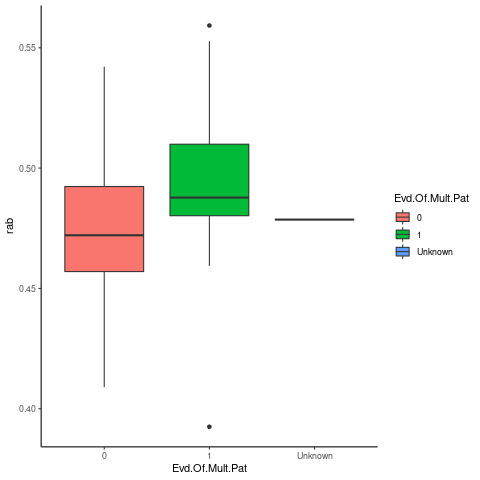

In [59]:
%%R
ggplot(motherOffspring, aes(x=Evd.Of.Mult.Pat, y=rab, fill=Evd.Of.Mult.Pat)) + 
    geom_boxplot() +
    theme_classic()

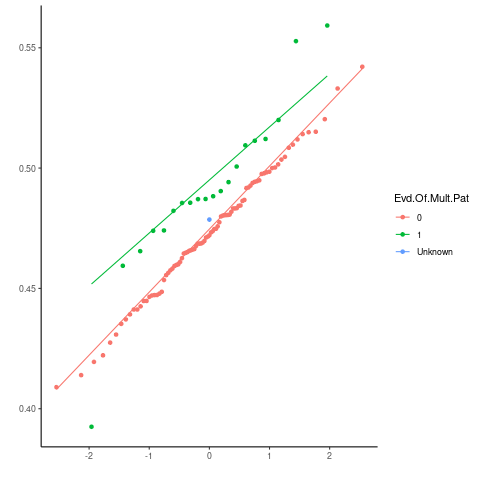

In [60]:
%%R
qplot(sample = rab, data= motherOffspring, color=Evd.Of.Mult.Pat) +
    theme_classic() + 
    stat_qq_line()

QQ plots show good evidence of normality in the non-mult. pat. group, and some deviance from normality in the mult. pat. group.

In [96]:
%%R
rab0 <- as.numeric(unlist(motherOffspring %>% filter(Evd.Of.Mult.Pat == 0) %>% select(rab)))
rab1 <- as.numeric(unlist(motherOffspring %>% filter(Evd.Of.Mult.Pat == 1) %>% select(rab)))
shapiro.test(rab0) # Very normal


	Shapiro-Wilk normality test

data:  rab0
W = 0.99561, p-value = 0.9921



In [70]:
%%R
shapiro.test(rab1) # Statistically significant deviation from normality


	Shapiro-Wilk normality test

data:  rab1
W = 0.90138, p-value = 0.04378



In [97]:
%%R
var.test(rab ~ Evd.Of.Mult.Pat, data = (motherOffspring %>% filter(Evd.Of.Mult.Pat != 'Unknown')), alternative = 'two.sided')


	F test to compare two variances

data:  rab by Evd.Of.Mult.Pat
F = 0.5851, num df = 90, denom df = 19, p-value = 0.09783
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.2628871 1.1023075
sample estimates:
ratio of variances 
         0.5851013 



Variances are not significantly different (*P = 0.09783)*

In [98]:
%%R
t.test(rab0, rab1)


	Welch Two Sample t-test

data:  rab0 and rab1
t = -2.2736, df = 24.117, p-value = 0.03218
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.035620648 -0.001726647
sample estimates:
mean of x mean of y 
0.4729008 0.4915744 



Mean relatedness between mothers and their offspring are significantly higher in mult. pat. litters than in non. mult. pat. (*P = 0.03218*)

Confirm with non-parametric test (Mann-Whitney U test), since there are outliers in the multiple paternity group. 

In [99]:
%%R
rabManWU <-wilcox.test(rab ~ Evd.Of.Mult.Pat, data = (motherOffspring %>% filter(Evd.Of.Mult.Pat != 'Unknown')), na.rm=TRUE, paired=FALSE, exact=FALSE, conf.int=TRUE)
print(rabManWU)


	Wilcoxon rank sum test with continuity correction

data:  rab by Evd.Of.Mult.Pat
W = 543, p-value = 0.004923
alternative hypothesis: true location shift is not equal to 0
95 percent confidence interval:
 -0.031959317 -0.005912661
sample estimates:
difference in location 
           -0.01849531 



Difference is more significant in non-parametric test (*P = 0.004923*)

### Comparing inbreeding coefficient

In [103]:
%%R
str(motherOffspring)

'data.frame':	112 obs. of  34 variables:
 $ family.A              : chr  "10" "10" "11" "11" ...
 $ b                     : int  97 122 160 160 142 142 72 126 91 94 ...
 $ a                     : int  25 97 123 127 74 130 14 72 87 87 ...
 $ sample.ID.A           : chr  "S3_AGAC" "S9_AGAC" "S11_CATC" "S11_GTGA" ...
 $ sample.ID.B           : chr  "S9_AGAC" "S11_AGTG" "S14_CTAC" "S14_CTAC" ...
 $ file_a                : chr  "ILL-RAD03_S3_L001_R1_001_AGAC.trim.bt2.bam" "ILL-RAD09_S9_L001_R1_001_AGAC.trim.bt2.bam" "ILL-RAD11_S11_L001_R1_001_CATC.trim.bt2.bam" "ILL-RAD11_S11_L001_R1_001_GTGA.trim.bt2.bam" ...
 $ file_b                : chr  "ILL-RAD09_S9_L001_R1_001_AGAC.trim.bt2.bam" "ILL-RAD11_S11_L001_R1_001_AGTG.trim.bt2.bam" "ILL-RAD14_S14_L001_R1_001_CTAC.trim.bt2.bam" "ILL-RAD14_S14_L001_R1_001_CTAC.trim.bt2.bam" ...
 $ nSites                : int  3361 2991 3457 3462 3280 3091 3570 3552 3389 3359 ...
 $ rab                   : num  0.474 0.494 0.458 0.458 0.511 ...
 $ Fa           

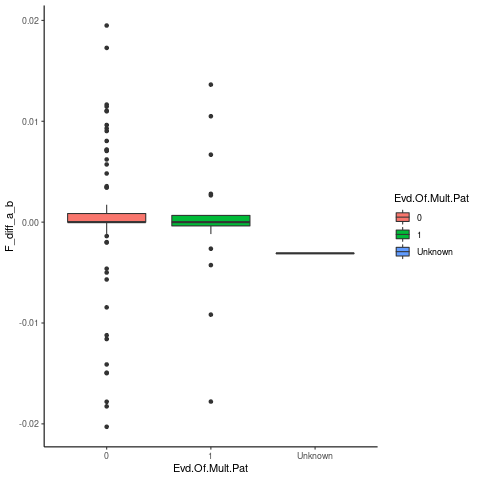

In [108]:
%%R
ggplot(motherOffspring, aes(x=Evd.Of.Mult.Pat, y=F_diff_a_b, fill=Evd.Of.Mult.Pat)) + 
    geom_boxplot() +
    theme_classic()

In [ ]:
### Put packages and versions in notebook

In [ ]:
# Poster dimensions: 42 x 36. Posters due Dec. 8. Finalized week before

### Conception date between single paternity and multiple paternity groups

In [91]:
%%R
sampleData <- read.delim("SampleData/sampleData.tab")
sampleData$Luther.Mother.ID. <- sapply(sampleData$Luther.Mother.ID., function(x) {return(as.numeric(substr(x,4,5)))} )
sampleData <- merge(sampleData, familyAssignments, by.x="Luther.Mother.ID.", by.y="row.names", all.x=TRUE)
sampleDataNoNA <- sampleData%>%filter(Evd.Of.Mult.Pat != 'Unknown')

In [92]:
%R str(sampleData)

'data.frame':	68 obs. of  19 variables:
 $ Luther.Mother.ID.            : num  1 2 3 4 5 6 7 8 9 10 ...
 $ Master.Deer.ID..             : int  2 3 4 5 8 9 10 13 16 29 ...
 $ Sex..M.F.                    : logi  FALSE FALSE FALSE FALSE FALSE FALSE ...
 $ Age.Estimate..previous.fall. : num  3.5 1.5 2.5 4.5 4.5 0.5 8.5 2.5 3.5 4.5 ...
 $ Tooth.taken.                 : chr  "" "x" "x" "x" ...
 $ K.Age                        : num  3.5 1.5 2.5 6.5 4.5 0.5 9.5 2.5 3.5 6.5 ...
 $ Date..mm.dd.yy.              : chr  "03/04/13" "04/08/13" "04/08/13" "04/09/13" ...
 $ County                       : chr  "Lucas" "Jones" "Dubuque" "Clinton" ...
 $ CO.Num                       : int  59 53 31 23 93 88 80 91 68 59 ...
 $ T                            : chr  "71N" "84N" "87N" "80N" ...
 $ R                            : chr  "23W" "2W" "1W" "3E" ...
 $ S                            : int  2 8 26 1 10 NA 1 20 25 32 ...
 $ Conception.Date..Julian.Days.: int  312 NA 328 319 328 NA 301 327 NA 318 ...
 $ Num

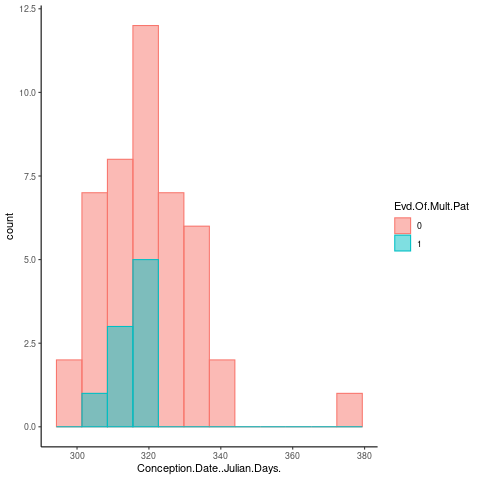

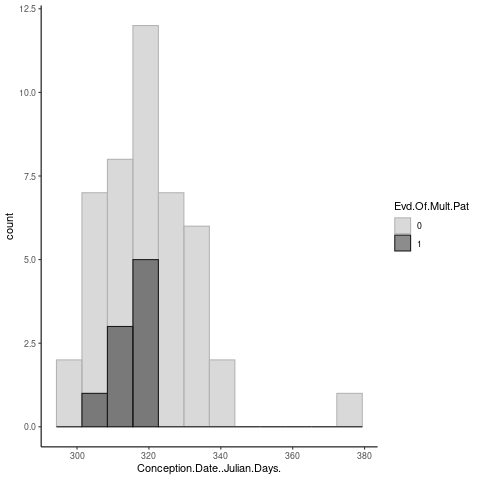

In [93]:
%%R
conceptionPlot <- ggplot(data=sampleDataNoNA, aes(x=Conception.Date..Julian.Days., fill=Evd.Of.Mult.Pat, color=Evd.Of.Mult.Pat)) +
    geom_histogram(position='identity',alpha=0.5,bins=12) +
    geom_vline(xintercept=mean((sampleData %>% filter(Evd.Of.Mult.Pat == 1))$conception_date, na.rm=TRUE), color='#619CFF') +
    geom_vline(xintercept=mean((sampleData %>% filter(Evd.Of.Mult.Pat == 0))$conception_date, na.rm=TRUE), color='#F8766D') +
    theme_classic()
print(conceptionPlot)
conceptionPlot + scale_fill_manual(values=c("grey70", "grey10")) + scale_color_manual(values=c("grey70", "grey10"))

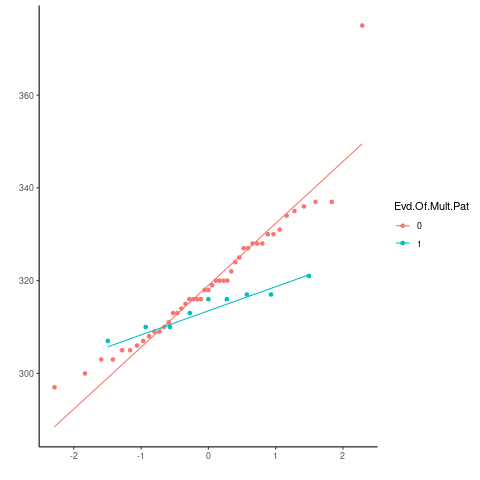

In [94]:
%%R
qplot(sample=Conception.Date..Julian.Days., data=sampleDataNoNA, color=Evd.Of.Mult.Pat) + theme_classic() + stat_qq_line()

In [102]:
%%R 
sampleDataNoNA.noOutliers <- sampleDataNoNA %>% filter(Conception.Date..Julian.Days. < 360)

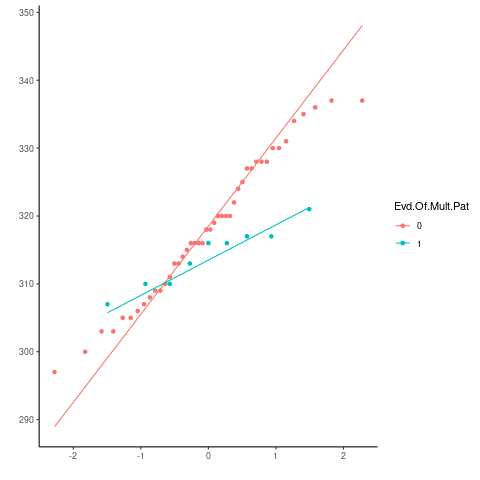

In [103]:
%%R
qplot(data=sampleDataNoNA.noOutliers, sample=Conception.Date..Julian.Days., color=Evd.Of.Mult.Pat) + theme_classic() + stat_qq_line()

In [122]:
%%R
shapiro.test(as.numeric(unlist(sampleDataNoNA.noOutliers %>% filter(Evd.Of.Mult.Pat == 0) %>% select(Conception.Date..Julian.Days.))))


	Shapiro-Wilk normality test

data:  as.numeric(unlist(sampleDataNoNA.noOutliers %>% filter(Evd.Of.Mult.Pat == 0) %>% select(Conception.Date..Julian.Days.)))
W = 0.97404, p-value = 0.4166



In [126]:
%%R
shapiro.test(as.numeric(unlist(sampleDataNoNA.noOutliers %>% filter(Evd.Of.Mult.Pat == 1) %>% select(Conception.Date..Julian.Days.))))


	Shapiro-Wilk normality test

data:  as.numeric(unlist(sampleDataNoNA.noOutliers %>% filter(Evd.Of.Mult.Pat == 1) %>% select(Conception.Date..Julian.Days.)))
W = 0.94617, p-value = 0.6481



In [128]:
%%R
var.test(Conception.Date..Julian.Days. ~ Evd.Of.Mult.Pat, sampleDataNoNA.noOutliers, alternative = 'two.sided')


	F test to compare two variances

data:  Conception.Date..Julian.Days. by Evd.Of.Mult.Pat
F = 5.8196, num df = 43, denom df = 8, p-value = 0.01285
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
  1.520158 14.571795
sample estimates:
ratio of variances 
          5.819607 

